In [1]:
%cd D:/jyupter_notebooks/Kaggle/sentiment-analysis-on-movie-reviews/Moview_Review_Sentiment_Analysis

D:\jyupter_notebooks\Kaggle\sentiment-analysis-on-movie-reviews\Moview_Review_Sentiment_Analysis


 0 - negative
 1 - somewhat negative
 2 - neutral
 3 - somewhat positive
 4 - positive

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')

In [21]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


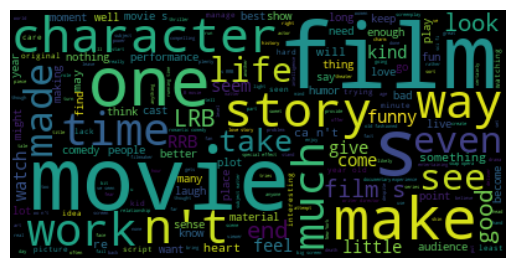

In [4]:
import nltk
from wordcloud import WordCloud, STOPWORDS
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in train_df.Phrase)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [5]:
data = train_df[['Phrase','Sentiment']].copy()
data.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


In [6]:
print('0: '+ str(len(data['Sentiment']==0)))
print('1: '+ str(len(data['Sentiment']==1)))
print('2: '+ str(len(data['Sentiment']==2)))
print('3: '+ str(len(data['Sentiment']==3)))
print('4: '+ str(len(data['Sentiment']==4)))

0: 156060
1: 156060
2: 156060
3: 156060
4: 156060


In [ ]:
#!python3 -m spacy download en_core_web_sm

In [9]:
import re
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

def remove_stopwords(text):
    text_tokens = text.split(" ")
    text_tokens_filtered = [word for word in text_tokens if not word in stopwords]
    return (" ").join(text_tokens_filtered)

def clean(text):
    text = re.sub(r'@|#',r'', text.lower())
    text = re.sub(r'http.*',r'',text.lower())
    return ' '.join(re.findall(r'\w+', text.lower()))

data['Phrase'] = data['Phrase'].apply(lambda x : clean(x))
data.head()

,Phrase,Sentiment
0,a series of escapades demonstrating the adage ...,1
1,a series of escapades demonstrating the adage ...,2
2,a series,2
3,a,2
4,series,2


In [23]:
data.Sentiment.values

array([2, 2, 2, ..., 1, 2, 2], dtype=int64)

In [10]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.index.values, 
                                                  data.Sentiment.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=data.Sentiment)

In [26]:
#data['data_type'] = ['not_set']*data.shape[0]
#print(data['data_type'])

In [11]:
# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train)

data['data_type'] = ['not_set']*data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'
data.loc[X_test, 'data_type'] = 'test'

data = data.dropna()

# Remove duplicates 
train_set = data[data['data_type'] == 'train'].drop_duplicates(ignore_index=True)
val_set = data[data['data_type'] == 'val'].drop_duplicates(ignore_index=True)
test_set = data[data['data_type'] == 'test'].drop_duplicates(ignore_index=True)

data = pd.concat([train_set, val_set, test_set], ignore_index=True)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)
data

,Phrase,Sentiment,data_type
0,george w bush henry kissinger,2,train
1,age wise,2,train
2,the potential,2,train
3,practically any like themed film other than it...,3,train
4,rarely has a film s title served such dire war...,0,val
...,...,...,...
149224,s not exactly worth,1,train
149225,welcome or accept the trials of henry kissinge...,3,train
149226,rarely seem sure of where it should go,1,train
149227,the dialogue,2,train


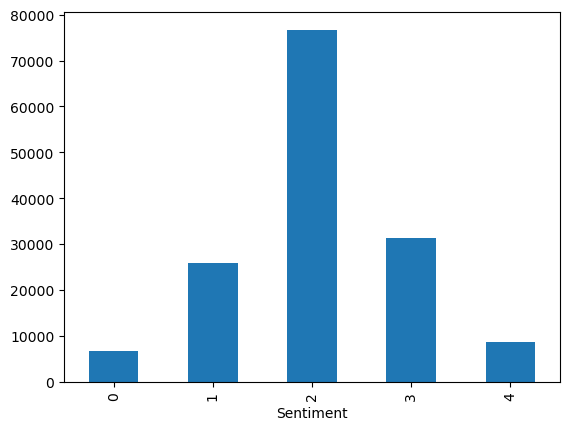

In [13]:
data.groupby("Sentiment").Sentiment.count().plot.bar(ylim=0)
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
X_train = train_set.Phrase.values
Y_train = train_set.Sentiment.values
X_test = test_set.Phrase.values
Y_test = test_set.Sentiment.values
target_categories = ["0","1","2","3","4"]

In [16]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
# print(X_test)

# Training the classifier with Naive Bayes
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])

nb.fit(X_train, Y_train)
test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

Naive Bayes Train Accuracy Score : 63% 
Naive Bayes Test Accuracy Score  : 59% 

              precision    recall  f1-score   support

           0       0.02      0.68      0.04        22
           1       0.24      0.51      0.32      1241
           2       0.91      0.60      0.73     11904
           3       0.38      0.54      0.44      2264
           4       0.04      0.62      0.08        65

    accuracy                           0.59     15496
   macro avg       0.32      0.59      0.32     15496
weighted avg       0.77      0.59      0.65     15496



In [17]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])

sgd.fit(X_train, Y_train)
test_predict = sgd.predict(X_test)

train_accuracy = round(sgd.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("SVM Train Accuracy Score : {}% ".format(train_accuracy))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

SVM Train Accuracy Score : 58% 
SVM Test Accuracy Score  : 56% 

              precision    recall  f1-score   support

           0       0.08      0.47      0.13       113
           1       0.10      0.47      0.17       598
           2       0.96      0.57      0.71     13329
           3       0.20      0.51      0.29      1272
           4       0.13      0.62      0.21       184

    accuracy                           0.56     15496
   macro avg       0.29      0.53      0.30     15496
weighted avg       0.85      0.56      0.65     15496



In [18]:
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean')),
               ])

knn.fit(X_train, Y_train)
test_predict = knn.predict(X_test)

train_accuracy = round(knn.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("K-Nearest Neighbour Train Accuracy Score : {}% ".format(train_accuracy))
print("K-Nearest Neighbour Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

K-Nearest Neighbour Train Accuracy Score : 73% 
K-Nearest Neighbour Test Accuracy Score  : 62% 

              precision    recall  f1-score   support

           0       0.36      0.41      0.38       610
           1       0.47      0.50      0.49      2557
           2       0.81      0.68      0.74      9374
           3       0.43      0.56      0.49      2501
           4       0.27      0.54      0.36       454

    accuracy                           0.62     15496
   macro avg       0.47      0.54      0.49     15496
weighted avg       0.66      0.62      0.63     15496



In [19]:
lr = Pipeline([('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(random_state=42, solver='liblinear')),
               ])

lr.fit(X_train, Y_train)
test_predict = lr.predict(X_test)

train_accuracy = round(lr.score(X_train, Y_train)*100)
test_accuracy = round(accuracy_score(test_predict, Y_test)*100)

print("Logistic Regression Train Accuracy Score : {}% ".format(train_accuracy))
print("Logistic Regression Test Accuracy Score  : {}% ".format(test_accuracy))
print()
print(classification_report(test_predict, Y_test, target_names=target_categories))

cm = confusion_matrix(Y_test, test_predict, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()

Logistic Regression Train Accuracy Score : 66% 
Logistic Regression Test Accuracy Score  : 63% 

              precision    recall  f1-score   support

           0       0.13      0.60      0.21       149
           1       0.31      0.53      0.39      1588
           2       0.90      0.65      0.76     10915
           3       0.44      0.57      0.50      2546
           4       0.22      0.67      0.33       298

    accuracy                           0.63     15496
   macro avg       0.40      0.61      0.44     15496
weighted avg       0.75      0.63      0.66     15496



In [20]:
# Load Huggingface transformers
from transformers import TFBertModel, BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SpatialDropout1D, Conv1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import LAMB, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'transformers'

In [ ]:
# Name of the BERT model to use
model_name = 'bert-base-cased'

# Max length of tokens
length = len(data.Phrase)
dff = [len(i.split(" ")) for i in data.Phrase[:length]]
max_length = max(dff)+3

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

In [ ]:
y_senti = to_categorical(data[data.data_type=='train'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='train'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

train = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
def map_func(input_ids, masks, labels):
    # convert three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

train = train.map(map_func)
batch_size = 32

# shuffle and batch - dropping any remaining samples that don't cleanly
train = train.shuffle(100).batch(batch_size, drop_remainder=True)

train.take(1)

In [ ]:
y_senti = to_categorical(data[data.data_type=='val'].Sentiment)

# Tokenize the input 
x = tokenizer(
    text=data[data.data_type=='val'].Phrase.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

val = tf.data.Dataset.from_tensor_slices((x['input_ids'], x['attention_mask'], y_senti))
val = val.map(map_func)
val = val.shuffle(100).batch(batch_size, drop_remainder=True)